In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from miniscope.imagingIO import loopMice, loadData, loadBeh, getBeh
from miniscope.analysis import dffCalc, filtData, smoothData, normData
from miniscope.events import getEvents, find_events, find_nearest
from miniscope.trials import markTrials
from miniscope.bouts import getBouts, getBouts_, getBoutDur, markBouts
from miniscope.statistics import stdCalc, getBoutMeans, getBoutMeans_, getStats
from miniscope.plotter import plotMean, plotHeat, plotTrials, plotHeatTrials

In [2]:
# Start gathering the data from FR1 experiment
# Mouse IDs and dataset IDs
mice = [(8404, 6), (8857, 3), (8864, 1)]
# Parameters
# Behavior type
behType = 'FR1'
# Imaging frame rate
fs = 0.05
# Which trials to include
trials=[1,12]
# Do you want to save?
save = False

In [3]:
# Get file paths for imaging data and behavior timestamps
fileList = loopMice(mice, behType)

# Load the imaging data
dataList = loadData(mice, behType)

# Load the behaviour timestamps
eventList = getBeh(mice, fileList['Behaviour'], behType)

In [4]:
# dFF and plot again
filtList = filtData(mice, dffCalc(mice, dataList, lowest=False), cutoff=5.0, order=6)
dFFList = smoothData(mice, filtList, window=10)

# Normalize the data
normList = normData(mice, dFFList)

# Get the events
eventStart = getEvents(mice, eventList, 'Eat_Start', trials)
eventEnd = getEvents(mice, eventList, 'Eat_End', trials)

In [5]:
# Pick the event
eventType = 'Eat_Start'
base = -10.0
duration = 30.0

# Find the marked events
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=False)

eventsdf = eventsData.pivot_table(index=['Event', 'New_Time'], columns='Cell', values='Fluoro')


3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.

3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.


In [6]:
def find_max(a):
    first = np.array([])
    second = np.array([])
    for i, j in enumerate(a):
        if a[0] == True:
            first = np.append(second, i+1)

        try:
            if a[i] == False and a[i+1] == True:
                first = np.append(first, i+1)
            if a[i] == True and a[i+1] == False:
                second = np.append(second, i+1)
        except:
            pass

        if a[len(a)-1] == True:
            second = np.append(second, i+1)
            
    print len(first), len(second)
    
    t_max = np.array([])
    y_max = np.array([])
    for i, j in enumerate(first):
        ind = int(first[i]+y[first[i]:second[i]].argmax())
        t_max = np.append(t_max, t[ind])
        y_max = np.append(y_max, y[ind])
    
    return t_max, y_max


In [9]:
from scipy.stats import sem
Start = getEvents(mice, eventList, 'Eat_Start', trials)
End = getEvents(mice, eventList, 'Eat_End', trials)
boutDuration = End - Start

"Mean bout duration: ", boutDuration.values.mean(), "sec." "Sem: ", sem(boutDuration.values, axis=None), "Std: ", np.std(boutDuration.values, axis=None)

('Mean bout duration: ',
 8.2775555555555691,
 'sec.Sem: ',
 0.41408818063353187,
 'Std: ',
 2.4497787138665399)

In [11]:
boutDuration

Mouse,8404,8857,8864
Trial,,,
1,8.487,11.720,7.876
2,11.231,13.036,6.797
3,12.457,10.880,8.440
4,6.170,10.200,6.276
5,6.936,10.321,5.155
6,7.287,9.026,5.003
7,6.625,9.965,7.566
8,2.299,8.909,7.977
9,5.120,9.310,8.809


In [ ]:
# Find the peaks and and event base times

C:\Anaconda2\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


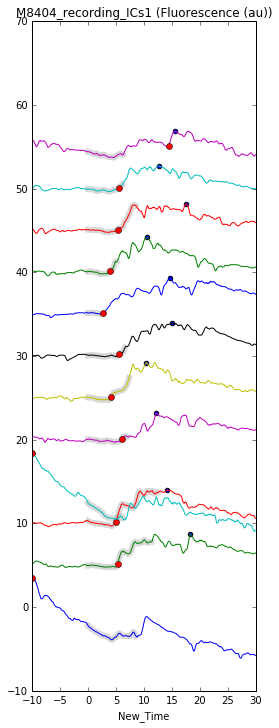

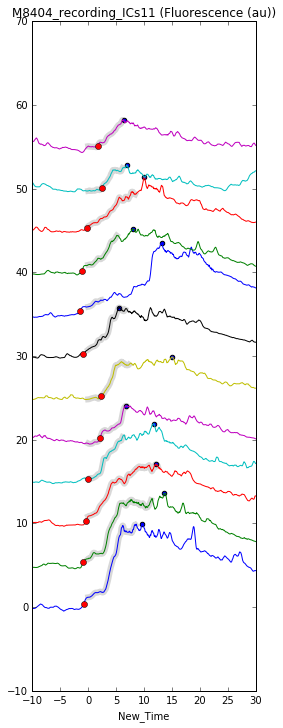

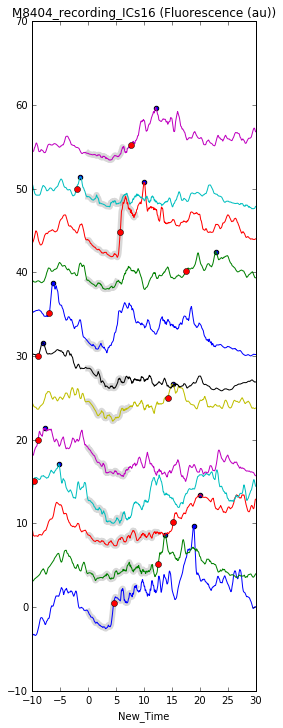

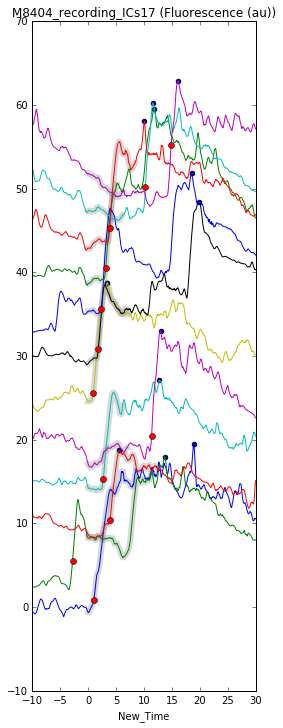

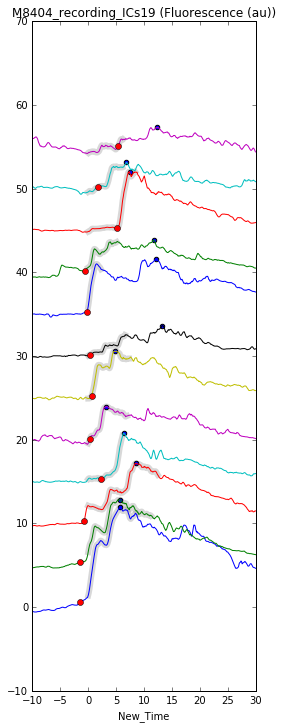

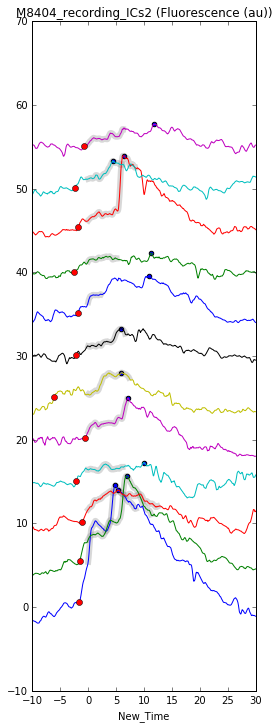

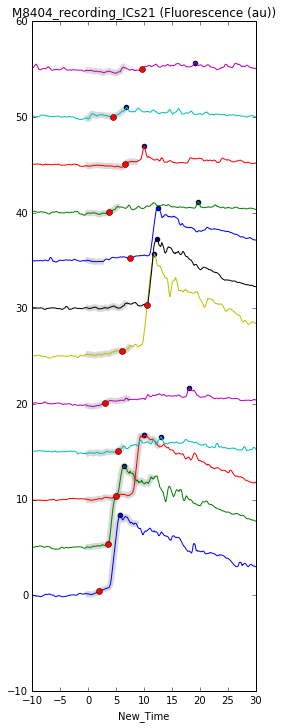

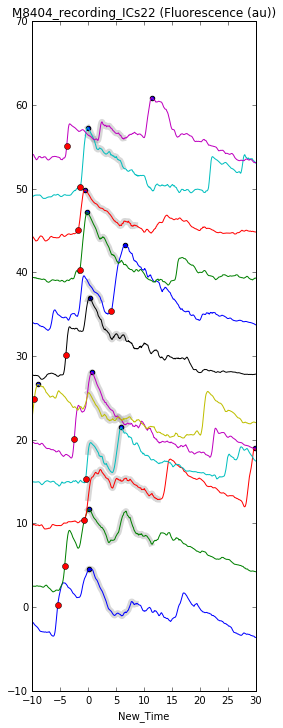

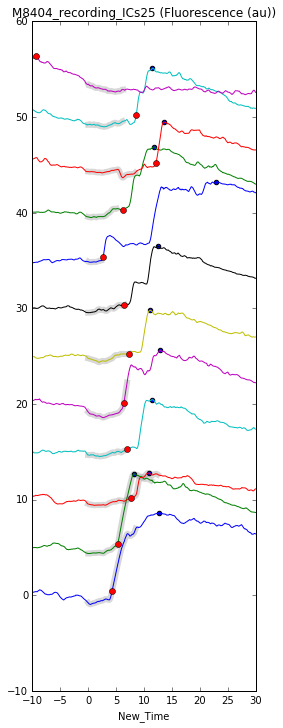

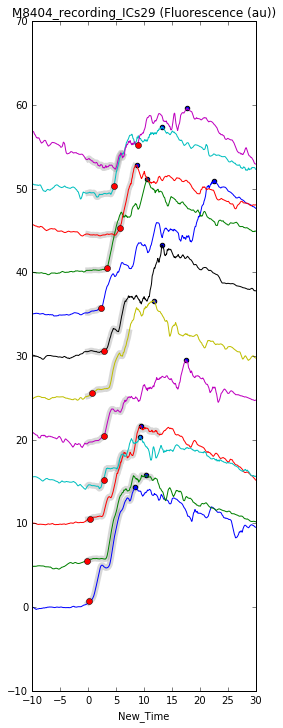

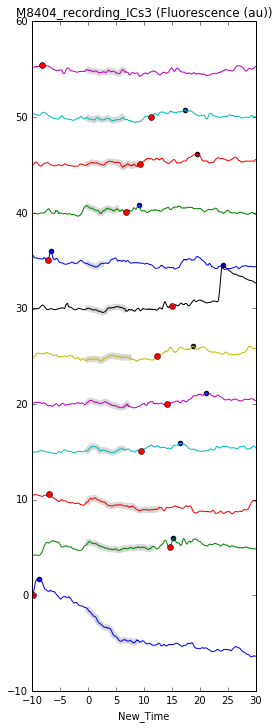

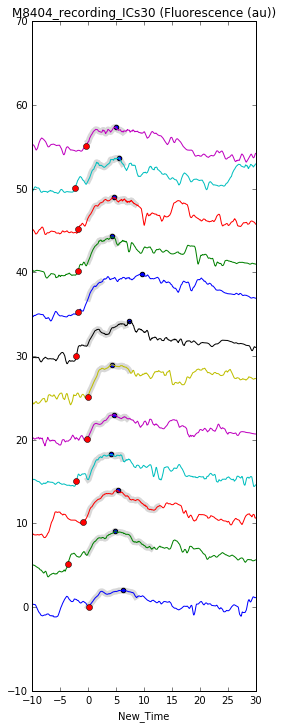

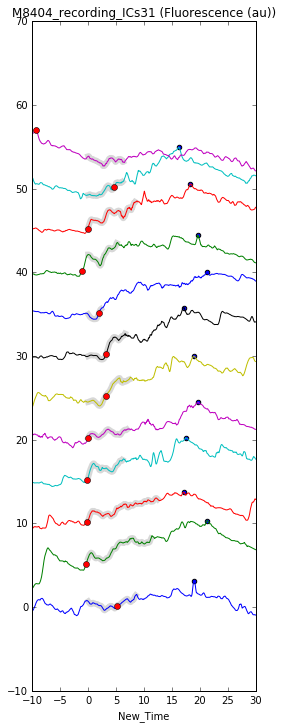

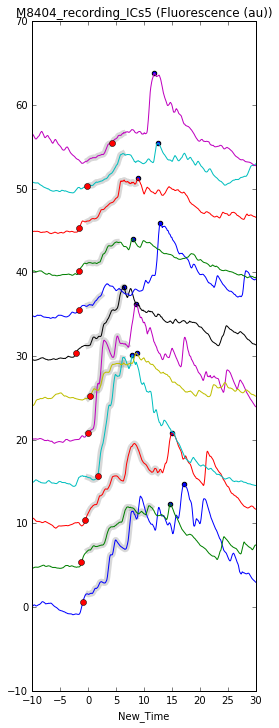

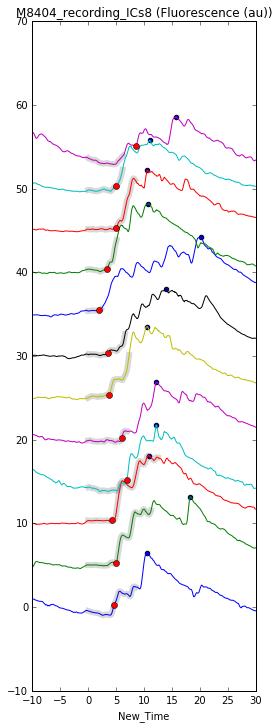

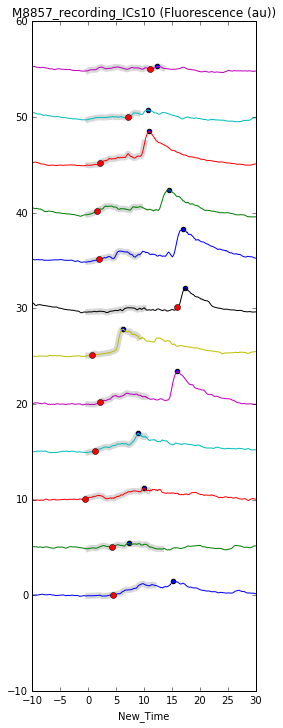

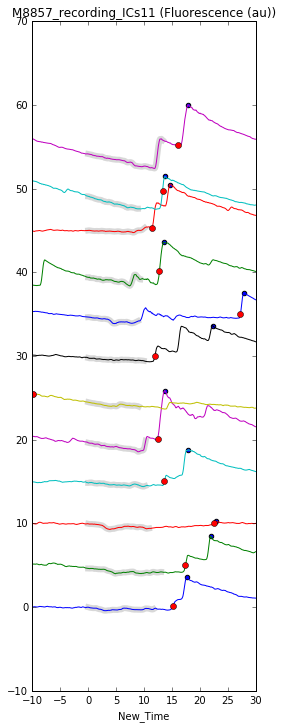

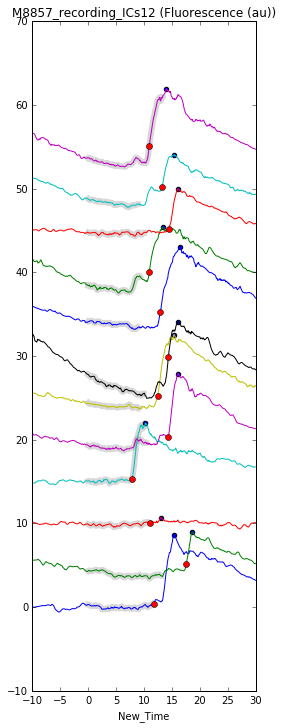

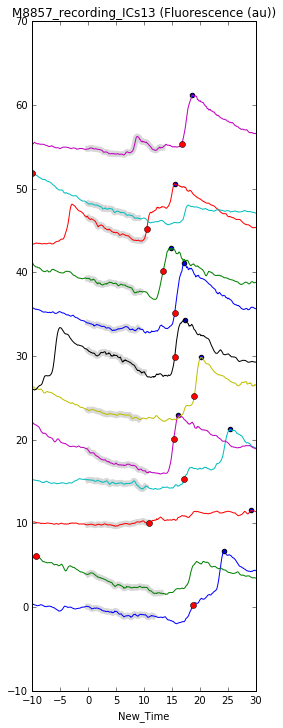

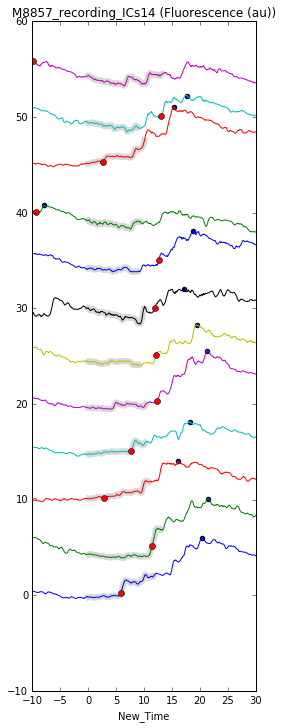

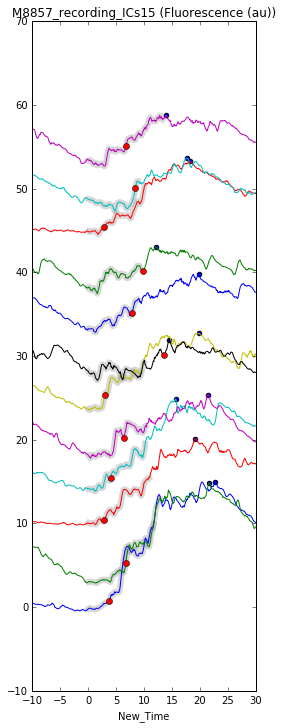

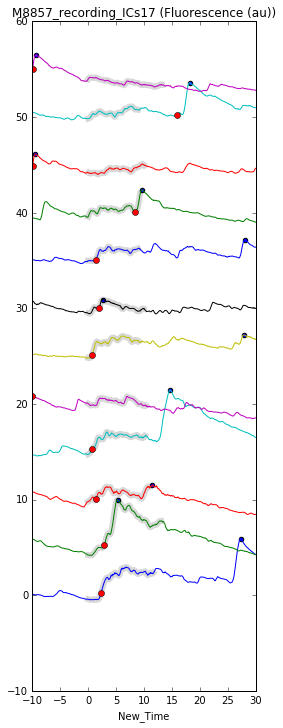

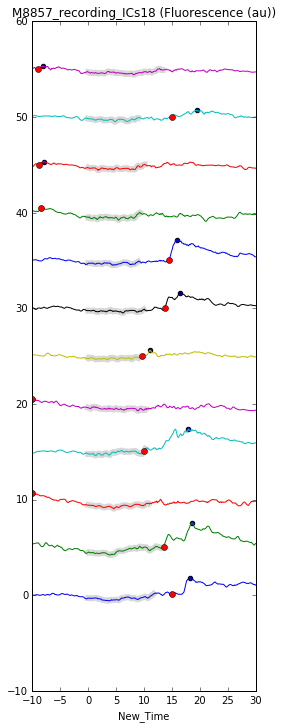

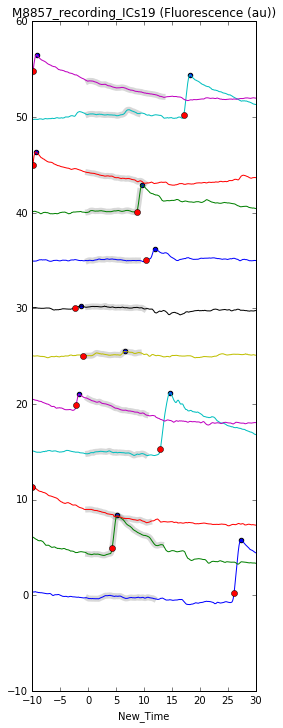

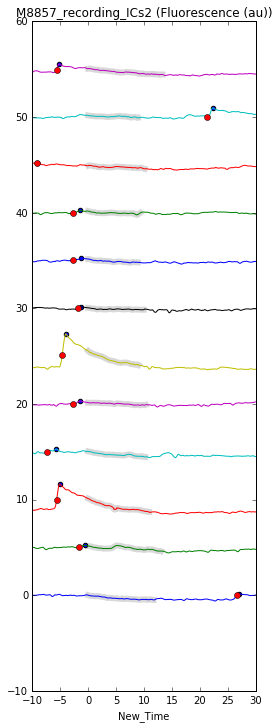

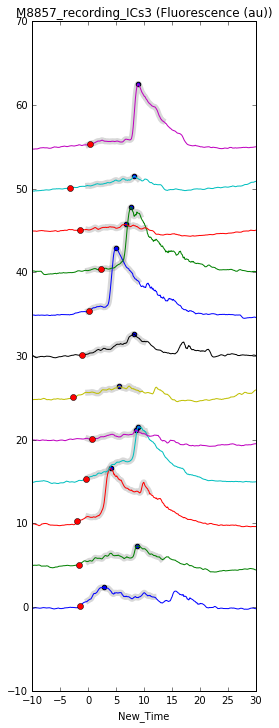

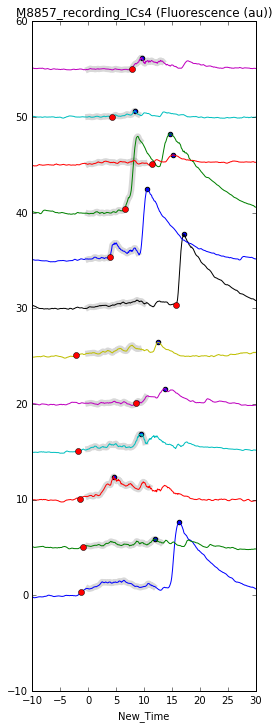

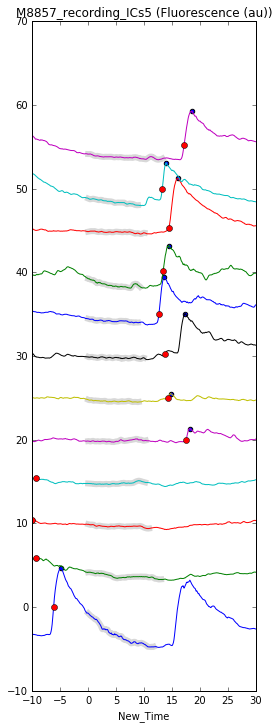

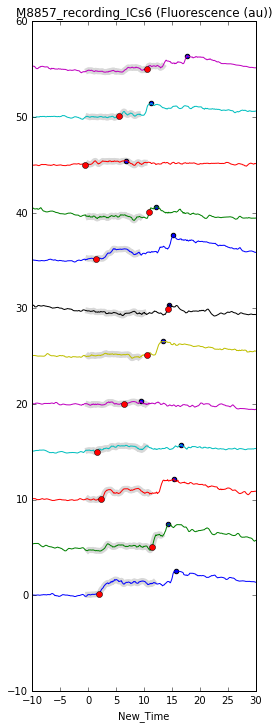

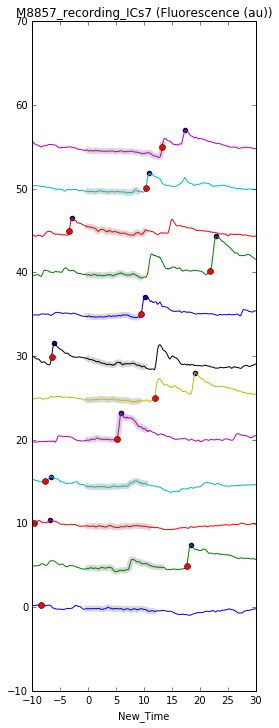

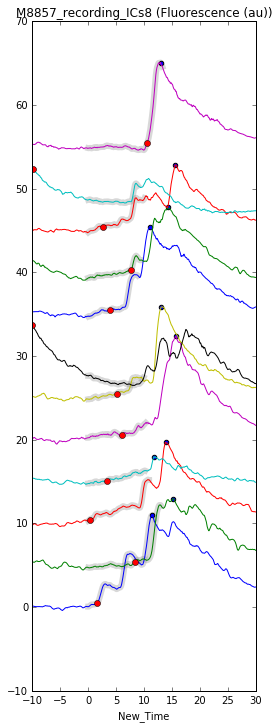

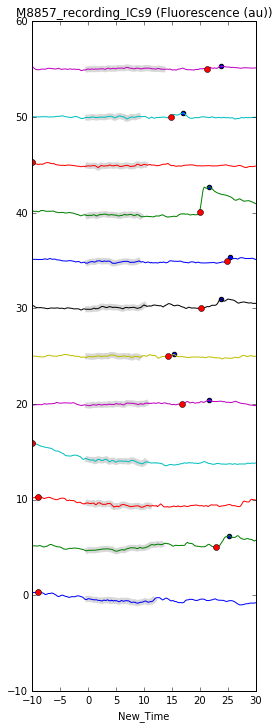

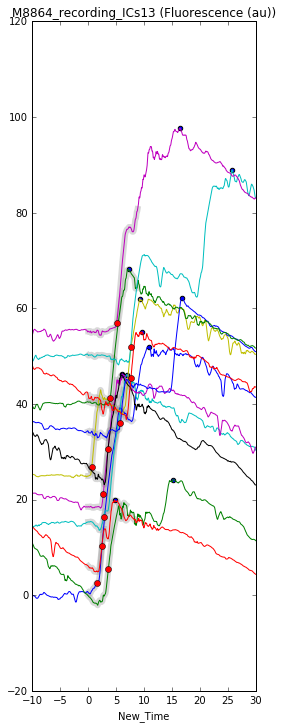

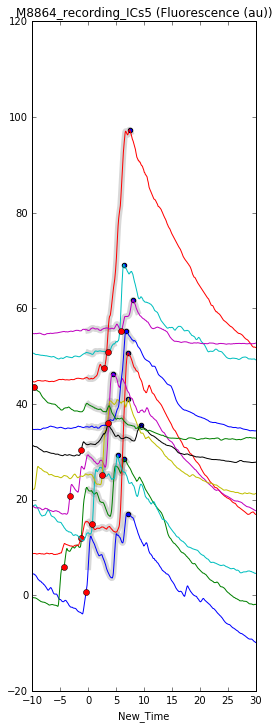

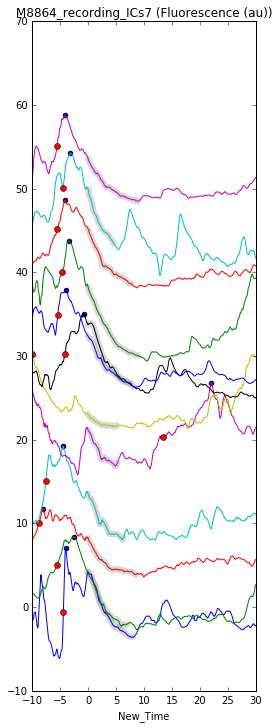

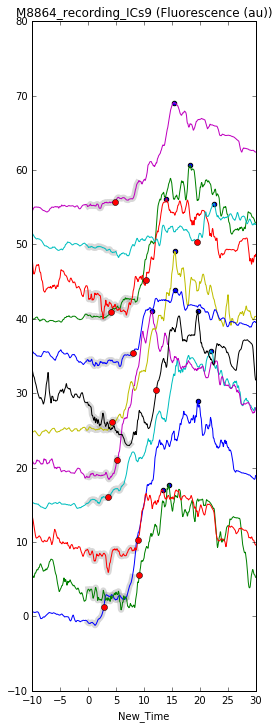

In [10]:
cells = eventsdf.columns
eventBase = pd.DataFrame()
eventPeak = pd.DataFrame()
for cell in cells:
    fig = plt.figure(figsize=(4, 12), facecolor="w", dpi= 150)
    ax = plt.subplot(111)

    offset = 0
    for trial in np.arange(trials[0], trials[1]+1):     
        y = eventsdf[cell].loc[trial]
        
        value = boutDuration[int(cell[1:5])].loc[trial]
        ind, event = find_nearest(y.index, value)
        
        (y+offset).plot(ax=ax, legend=False)
        plt.scatter(y.idxmax(), y[y.idxmax()]+offset)

        lowest = np.array([y.idxmax()])
        for j in y[:y.idxmax()].index:
            if y[j] <= 0.05*y[y.idxmax()]:
                lowest = np.append(lowest, j)

        eventBase = eventBase.append(pd.DataFrame({'Event_Base_Time':[lowest[-1]], 'Event_Base_Value':[y[lowest[-1]]], 'Trial':[trial], 'Cell':[cell]}))
        eventPeak = eventPeak.append(pd.DataFrame({'Event_Peak_Time':[y.idxmax()], 'Event_Peak_Value':[y[y.idxmax()]], 'Trial':[trial], 'Cell':[cell]}))
        
        ax.plot(lowest[-1], y[lowest[-1]]+offset, 'ro')
        
        ax.plot(y[0:event].index, y[0:event]+offset, 'gray', linewidth=6, alpha=0.3, zorder=-1)
        
        ax.set_title(cell)

        offset = offset + 5

eventBase.reset_index(inplace=True)
eventPeak.reset_index(inplace=True)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  from ipykernel import kernelapp as app


{'boxes': [<matplotlib.lines.Line2D at 0xce11ba8>,
 'caps': [<matplotlib.lines.Line2D at 0x24d66b70>,
 'fliers': [<matplotlib.lines.Line2D at 0x24d73c18>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x24d736a0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x24d52fd0>,
  <matplotlib.lines.Line2D at 0x1d44fbe0>]}

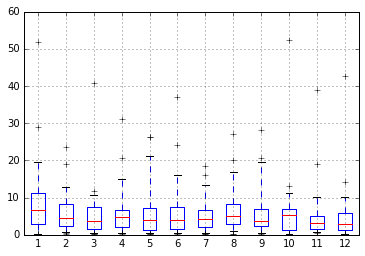

In [12]:
#eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T.boxplot(whis=[5, 95])
eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.boxplot(whis=[5, 95])
#eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.boxplot(whis=[5, 95])

In [13]:
#eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T.mean()
eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.mean()
#eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.mean()

Trial
1     8.942821
2     6.084765
3     5.447905
4     5.957212
5     6.157967
6     6.097880
7     5.064004
8     6.708471
9     5.567979
10    6.095333
11    4.657855
12    4.812507
dtype: float64

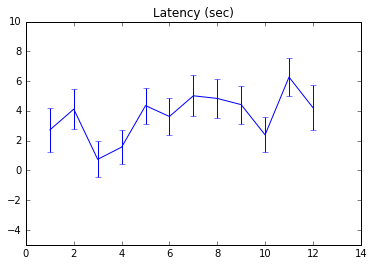

In [14]:
mean=eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.mean()
sem=eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.sem()
plt.errorbar(np.arange(1,13), mean.values, yerr=sem.values)
plt.xlim(0, 14)
plt.ylim(-5, 10)
plt.title("Latency (sec)")
eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.to_csv("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\trials\\trials_latency_from_eat_start.csv")

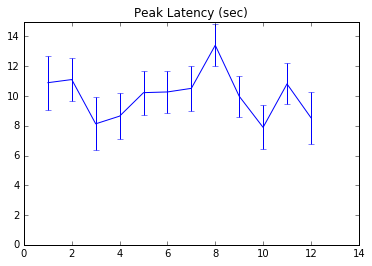

In [15]:
mean=eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T.mean()
sem=eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T.sem()
plt.errorbar(np.arange(1,13), mean.values, yerr=sem.values)
plt.xlim(0, 14)
plt.ylim(0, 15)
plt.title("Peak Latency (sec)")
eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T.to_csv("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\trials\\trials_peaklatency_from_eat_start.csv")

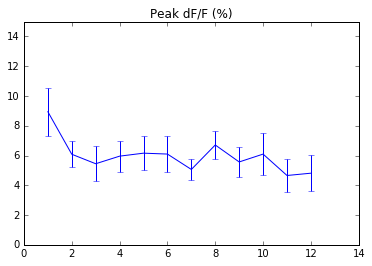

In [16]:
mean=eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.mean()
sem=eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.sem()
plt.errorbar(np.arange(1,13), mean.values, yerr=sem.values)
plt.xlim(0, 14)
plt.ylim(0, 15)
plt.title("Peak dF/F (%)")
#eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.to_csv("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\trials\\trials_peak_from_eat_start.csv")

In [17]:
len(eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T)

36

In [18]:
eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.std(axis=1)

Cell
M8404_recording_ICs1 (Fluorescence (au))      6.778459
M8404_recording_ICs11 (Fluorescence (au))     1.462738
M8404_recording_ICs16 (Fluorescence (au))    10.367763
M8404_recording_ICs17 (Fluorescence (au))     5.077004
M8404_recording_ICs19 (Fluorescence (au))     2.333497
M8404_recording_ICs2 (Fluorescence (au))      1.435290
M8404_recording_ICs21 (Fluorescence (au))     2.624650
M8404_recording_ICs22 (Fluorescence (au))     3.315194
M8404_recording_ICs25 (Fluorescence (au))     5.177097
M8404_recording_ICs29 (Fluorescence (au))     2.621108
M8404_recording_ICs3 (Fluorescence (au))     10.016202
M8404_recording_ICs30 (Fluorescence (au))     1.123610
M8404_recording_ICs31 (Fluorescence (au))     3.783104
M8404_recording_ICs5 (Fluorescence (au))      1.774824
M8404_recording_ICs8 (Fluorescence (au))      1.758809
M8857_recording_ICs10 (Fluorescence (au))     4.830277
M8857_recording_ICs11 (Fluorescence (au))     8.787336
M8857_recording_ICs12 (Fluorescence (au))     2.449718
M8857

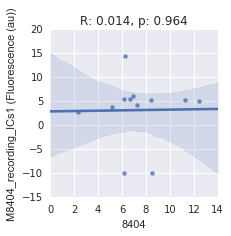

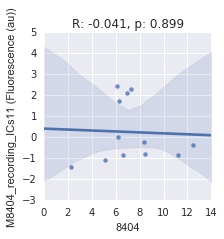

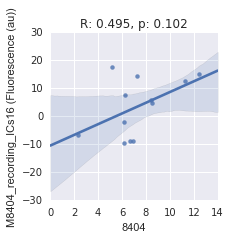

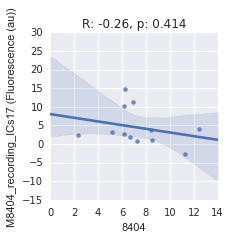

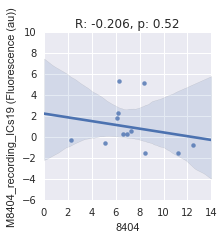

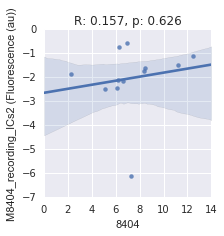

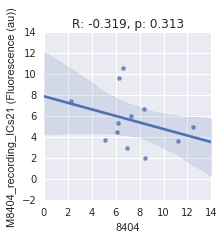

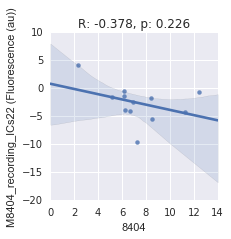

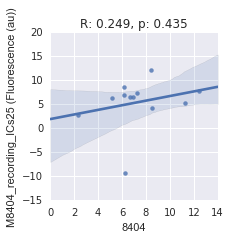

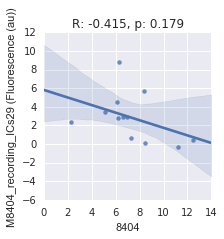

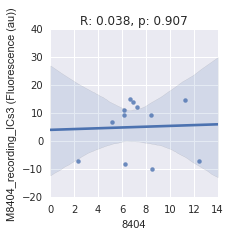

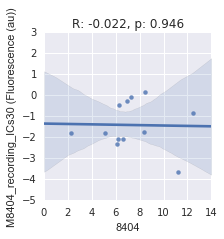

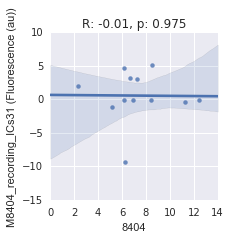

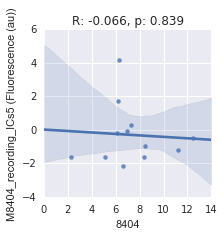

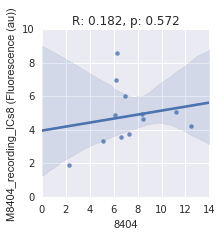

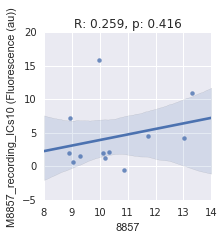

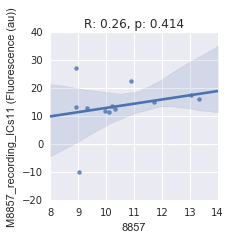

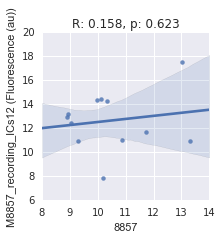

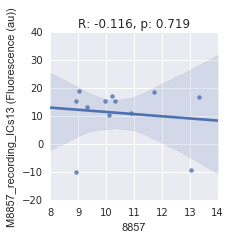

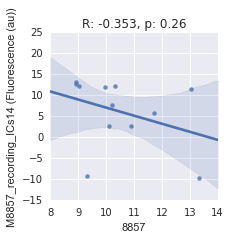

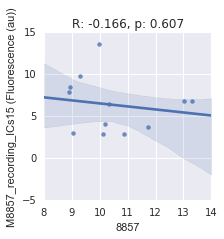

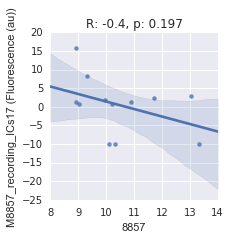

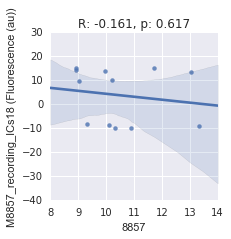

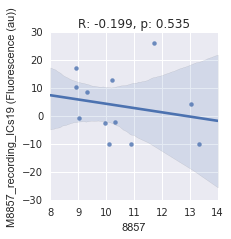

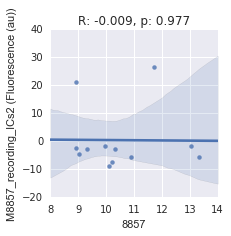

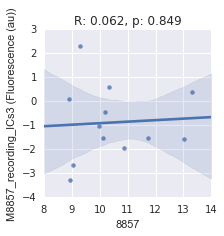

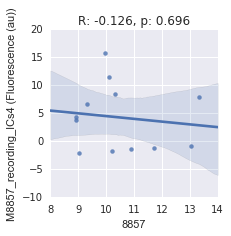

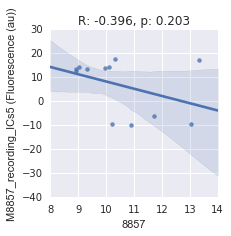

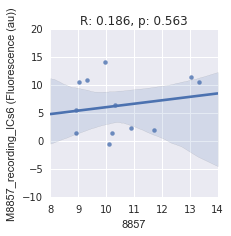

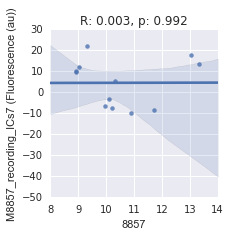

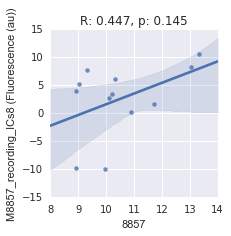

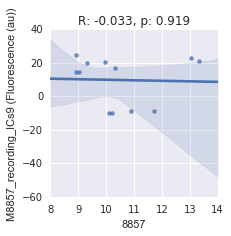

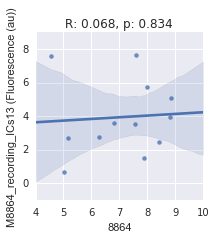

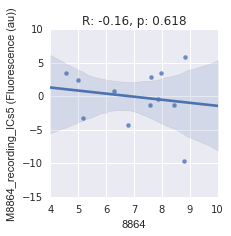

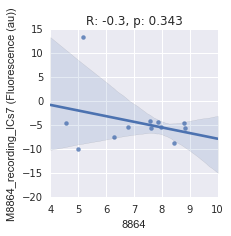

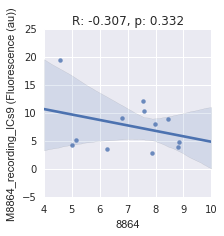

In [19]:
import scipy.stats as st
import seaborn as sns
for k in np.arange(0,len(eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T)):
    name=eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.iloc[k].name
    dur=boutDuration[int(name[1:5])]
    lat=eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.iloc[k]
    
    fig=plt.figure(figsize=(3,3))
    ax=plt.subplot(111)
    sns.regplot(dur, lat, ax=ax)

    tit="R: "+str(np.round(st.linregress(dur,lat).rvalue, 3))+", p: "+str(np.round(st.linregress(dur,lat).pvalue, 3))
    ax.set_title(tit)

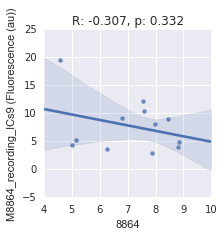

In [20]:
import scipy.stats as st
import seaborn as sns

name=eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.iloc[k].name
dur=boutDuration[int(name[1:5])]
lat=eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.iloc[k]

fig=plt.figure(figsize=(3,3))
ax=plt.subplot(111)
sns.regplot(dur, lat, ax=ax)

tit="R: "+str(np.round(st.linregress(dur,lat).rvalue, 3))+", p: "+str(np.round(st.linregress(dur,lat).pvalue, 3))
ax.set_title(tit)

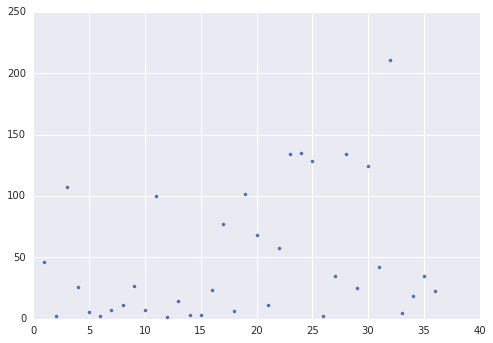

In [21]:
vary=eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.var(axis=1)
cell_n=np.arange(1, len(vary.index)+1)
plt.plot(cell_n, vary, '.')

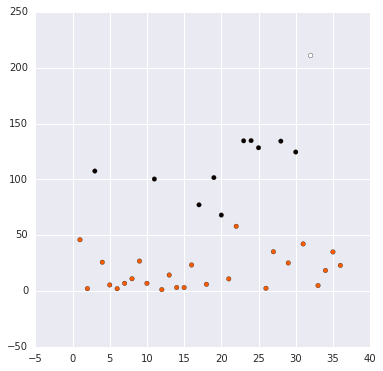

In [22]:
from sklearn.cluster import KMeans

X = pd.DataFrame({'var':vary,'cell_n':cell_n})

kmean = KMeans(n_clusters=3, max_iter=1000, random_state=1000).fit_predict(X.values)

fig=plt.figure(figsize=(6,6))
ax=plt.subplot(111)

ax.scatter(X.values[:, 0], X.values[:, 1], c=kmean, cmap=plt.cm.hot)

In [23]:
statsFR1whole = pd.read_pickle("C:\\Users\\hakan\\Documents\\statsFR1whole.pkl")

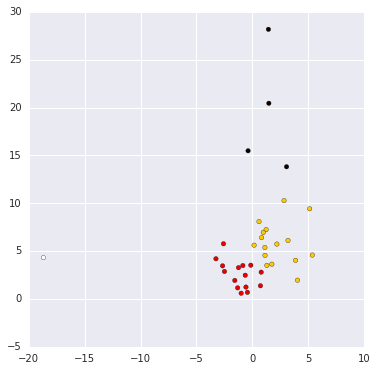

In [24]:
from sklearn.cluster import KMeans

#X = pd.DataFrame({'PI':statsFR1whole['PInd'],'Latency':eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.mean(axis=1)})
X = pd.DataFrame({'PI':statsFR1whole['PInd'],'Peak':eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.mean(axis=1)})

kmean = KMeans(n_clusters=4, max_iter=1000, random_state=1000).fit_predict(X.values)

fig=plt.figure(figsize=(6,6))
ax=plt.subplot(111)

ax.scatter(X.values[:, 0], X.values[:, 1], c=kmean, cmap=plt.cm.hot)

#X.index[kmean==3]

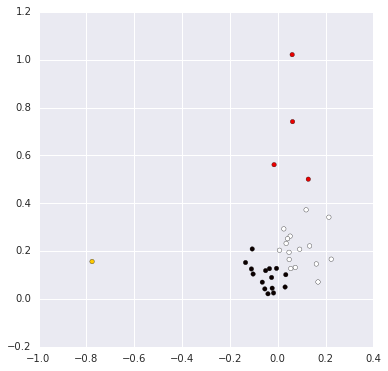

In [25]:
from sklearn.cluster import KMeans

#X = pd.DataFrame({'PI':statsFR1whole['PInd'],'Latency':eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.mean(axis=1)})
X = pd.DataFrame({'PI':statsFR1whole['PInd'],'Peak':eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.mean(axis=1)})
X=X/(X.max(axis=0)-X.min(axis=0))

kmean = KMeans(n_clusters=4, max_iter=1000, random_state=1000).fit_predict(X.values)

fig=plt.figure(figsize=(6,6))
ax=plt.subplot(111)

ax.scatter(X.values[:, 0], X.values[:, 1], c=kmean, cmap=plt.cm.hot)

#X.index[kmean==3]

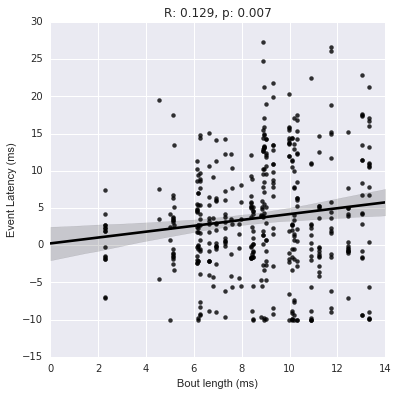

In [26]:
# Bout length vs Event Latency
import seaborn as sns
dur=np.array([])
lat=np.array([])
for k in np.arange(0,len(eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T)):
    name=eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.iloc[k].name
    dur=np.append(dur, boutDuration[int(name[1:5])])
    lat=np.append(lat, eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.iloc[k])

fig=plt.figure(figsize=(6,6))
ax=plt.subplot(111)
sns.regplot(dur, lat, ax=ax, color='k')

ax.set_xlabel("Bout length (ms)")
ax.set_ylabel("Event Latency (ms)")

import scipy.stats as st
tit="R: "+str(np.round(st.linregress(dur,lat).rvalue, 3))+ ", p: "+str(np.round(st.linregress(dur,lat).pvalue, 3))
ax.set_title(tit)

In [ ]:
import seaborn as sns
dur=np.array([])
lat=np.array([])
for k in np.arange(0,len(eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T)):
    name=eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T.iloc[k].name
    dur=np.append(dur, boutDuration[int(name[1:5])])
    lat=np.append(lat, eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T.iloc[k])

fig=plt.figure(figsize=(6,6))
ax=plt.subplot(111)
sns.regplot(dur, lat, ax=ax, color='k')

ax.set_xlabel("Bout length (ms)")
ax.set_ylabel("Event Latency (ms)")

import scipy.stats as st
tit="R: "+str(np.round(st.linregress(dur,lat).rvalue, 3))+", p: "+str(np.round(st.linregress(dur,lat).pvalue, 3))
ax.set_title(tit)

In [ ]:
import scipy.stats as st
import seaborn as sns
for k in np.arange(0,len(eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T)):
    name=eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.iloc[k].name
    dur=np.append(dur, boutDuration[int(name[1:5])])
    lat=np.append(lat, eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.iloc[k])
    
    fig=plt.figure(figsize=(3,3))
    ax=plt.subplot(111)
    sns.regplot(dur, lat, ax=ax)

    tit="R: "+str(np.round(st.linregress(dur,lat).rvalue, 3))+", p: "+str(np.round(st.linregress(dur,lat).pvalue, 3))
    ax.set_title(tit)

In [ ]:
import seaborn as sns
dur=np.array([])
lat=np.array([])
for k in np.arange(0,len(eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T)):
    name=eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.iloc[k].name
    dur=np.append(dur, boutDuration[int(name[1:5])])
    lat=np.append(lat, eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.iloc[k])

fig=plt.figure(figsize=(6,6))
ax=plt.subplot(111)
sns.regplot(dur, lat, ax=ax)

import scipy.stats as st
tit="R: "+str(np.round(st.linregress(dur,lat).rvalue, 3))+", p: "+str(st.linregress(dur,lat).pvalue)
ax.set_title(tit)

In [ ]:
ibi=(Start-Start.shift()).dropna()
ibi

In [ ]:
## Peak vs IBI
import seaborn as sns
dur=np.array([])
lat=np.array([])
ibi=(Start-Start.shift()).dropna()
for k in np.arange(0,len(eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T)):
    name=eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.iloc[k].name
    dur=np.append(dur, ibi[int(name[1:5])])
    lat=np.append(lat, eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.iloc[k][1:])

fig=plt.figure(figsize=(6,6))
ax=plt.subplot(111)
sns.regplot(dur, lat, ax=ax)

import scipy.stats as st
tit="R: "+str(np.round(st.linregress(dur,lat).rvalue, 3))+", p: "+str(st.linregress(dur,lat).pvalue)
ax.set_title(tit)

In [ ]:
## Latency vs IBI
import seaborn as sns
dur=np.array([])
lat=np.array([])
ibi=(Start-Start.shift()).dropna()
for k in np.arange(0,len(eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Value').T)):
    name=eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Value').T.iloc[k].name
    dur=np.append(dur, ibi[int(name[1:5])])
    lat=np.append(lat, eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Value').T.iloc[k][1:])

fig=plt.figure(figsize=(6,6))
ax=plt.subplot(111)
sns.regplot(dur, lat, ax=ax)

import scipy.stats as st
tit="R: "+str(np.round(st.linregress(dur,lat).rvalue, 3))+", p: "+str(st.linregress(dur,lat).pvalue)
ax.set_title(tit)

In [ ]:
## Peak Latency vs IBI
import seaborn as sns
dur=np.array([])
lat=np.array([])
ibi=(Start-Start.shift()).dropna()
for k in np.arange(0,len(eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T)):
    name=eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T.iloc[k].name
    dur=np.append(dur, ibi[int(name[1:5])])
    lat=np.append(lat, eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T.iloc[k][1:])

fig=plt.figure(figsize=(6,6))
ax=plt.subplot(111)
sns.regplot(dur, lat, ax=ax)

import scipy.stats as st
tit="R: "+str(np.round(st.linregress(dur,lat).rvalue, 3))+", p: "+str(np.round(st.linregress(dur,lat).pvalue, 3))
ax.set_title(tit)

In [ ]:
## Peak Latency vs Peak
import seaborn as sns
peak=np.array([])
lat=np.array([])
for k in np.arange(0,len(eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T)):
    name=eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T.iloc[k].name
    peak=np.append(dur, eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.iloc[k])
    lat=np.append(lat, eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T.iloc[k])

fig=plt.figure(figsize=(6,6))
ax=plt.subplot(111)
sns.regplot(dur, lat, ax=ax)

import scipy.stats as st
tit="R: "+str(np.round(st.linregress(dur,lat).rvalue, 3))+", p: "+str(np.round(st.linregress(dur,lat).pvalue, 3))
ax.set_title(tit)

In [ ]:
## Latency vs Peak
import seaborn as sns
peak=np.array([])
lat=np.array([])
for k in np.arange(0,len(eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T)):
    name=eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Time').T.iloc[k].name
    peak=np.append(dur, eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.iloc[k])
    lat=np.append(lat, eventBase.pivot_table(index='Trial', columns='Cell', values='Event_Base_Time').T.iloc[k])

fig=plt.figure(figsize=(6,6))
ax=plt.subplot(111)
sns.regplot(dur, lat, ax=ax)

import scipy.stats as st
tit="R: "+str(np.round(st.linregress(dur,lat).rvalue, 3))+", p: "+str(np.round(st.linregress(dur,lat).pvalue, 3))
ax.set_title(tit)

In [ ]:
var=eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.var(axis=1)
mean=eventPeak.pivot_table(index='Trial', columns='Cell', values='Event_Peak_Value').T.mean(axis=1)

fig=plt.figure(figsize=(6,6))
ax=plt.subplot(111)
ax.plot(mean, var, 'r.')
ax.set_xlim([-10,20])
ax.set_ylim([-10,20])

In [ ]:
X=pd.DataFrame({'var':var.values, 'mean':mean.values},index=var.index)
X.values

In [ ]:
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters=5, max_iter=1000, random_state=1000).fit_predict(X.values)

fig=plt.figure(figsize=(6,6))
ax=plt.subplot(111)

ax.scatter(X.values[:, 0], X.values[:, 1], c=kmean)

print kmean

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1500, random_state=170)

In [ ]:
X

In [ ]:
# Start running the analysis for Fixed-Ratio
# Baseline before Eat_Start and compare to the eating bout

# Eating bout
Start = getEvents(mice, eventList, 'Eat_Start', trials)
End = getEvents(mice, eventList, 'Eat_End', trials)
eventStart = Start
eventEnd = End
baseEvent = Start
# Baseline equal to the event duration
base = Start-End

boutsDatawhole =  getBouts_(mice, dFFList, eventStart, eventEnd, baseEvent, base, behType, trials, baselining=False)
#boutsData =  getBouts(mice, dFFList, eventStart, eventEnd, baseEvent, base, behType, trials, baselining=False)
boutMeansFR1whole = getBoutMeans_(mice, boutsDatawhole, behType=behType, trials=trials, base=base, fs=fs)

[statsFR1whole, percFR1whole] = getStats(boutMeansFR1whole, choice='Ranksum', parameter='Auc', p_val=0.05)

plt.style.use('classic')
# Set the font dictionaries (for plot title and axis titles)
font = {'sans-serif':'Arial', 'weight':'normal', 'size':12}
plt.rc('font', **font)

line = 1.5

fig = plt.figure(figsize=(3,3), facecolor="w", dpi= 150)
ax = plt.subplot(111)
percFR1whole.T.plot.pie(ax=ax, y='Percentage (%)', autopct='%1.1f%%', explode=[.02,.02,.02], startangle=0, fontsize=12, legend=False, cmap=plt.cm.PiYG_r)
wedges = [patch for patch in ax.patches if isinstance(patch, mpatches.Wedge)]
for w in wedges:
    w.set_linewidth(line)
    w.set_edgecolor('w')

In [ ]:
cellsUp=statsFR1whole[statsFR1whole['Class'] == 'Up'].index

In [ ]:
# Look at the event PSTHs

In [ ]:
# Pick the event
save = False
eventType = 'Eat_Start'
base = -10.0
duration = 30.0

# Plot the mean of all
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=False)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)

fig, ax = plotMean(mean, sem, time, eventType)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\for Amelia\\"+"2_"+eventType+"_all_trials_mean_base_"+str(base)+"sec.svg"
if 0:    
    fig.savefig(fname)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\heatmaps\\"+"2_"+eventType+ "_all_trials_heatmap_"+str(base)+"sec.svg"
fig2, ax2 = plotHeat(eventsData_norm, eventType, base, duration, trials, fs=0.05, vlim=[0.0,0.55])
if 0:
    fig2.savefig(fname)

In [ ]:
heatData = eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').values
[row, col] = heatData.shape
vlim=False
save=False
plt.style.use('classic')
# Set the font dictionaries (for plot title and axis titles)
font = {'sans-serif' : 'Arial',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

fig = plt.figure(figsize=(5,10), facecolor="w", dpi= 150)
ax = plt.subplot(111)

line = 1.5
colors = ('#BCBEC0', '#0070C0', '#BCBEC0', '#0070C0')

if vlim:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid', vmin=vlim[0], vmax=vlim[1])
else:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid')

ax.set_yticks(np.linspace(0.5, row-0.5, 2))
ax.set_yticklabels(np.linspace(1, row, 2, dtype=int))
ax.set_ylim(0, row)

ax.invert_yaxis()
cbar = plt.colorbar(ax=ax)
cbar.set_label("Normalized dF/F")

## labels
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Trial #')
ax.set_title(eventType)

## decorate the axes
#ax.tick_params(axis='y', color= '#000000', width= line, direction='in', length= 4, which='major', pad=10)
#ax.tick_params(axis='x', color= '#000000', width= line, direction='in', length= 4, which='major', pad=12)
time_ax = np.arange(base, duration+0.001, 5.0)
ax.set_xticks(np.linspace(0, (-base+duration)/fs, len(time_ax)))
ax.set_xticklabels(time_ax)

ax.plot([-base/fs, -base/fs], list(ax.get_ylim()), 'w', linestyle='--', linewidth=line*1.2, alpha=1., zorder=111)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"_"+eventType+ "_everything_heatmap_"+str(base)+"sec.png"
if save:
    fig.savefig(fname)

In [ ]:
heatData = eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[1]

heatTrials = pd.DataFrame()
for ind in np.arange(trials[0], trials[1]+1):
    heatData = eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[ind]

    sortAx = heatData.mean(axis=1)
    heatData
    heatData['Cell_Mean'] = sortAx
    heatData = heatData.sort_values(by='Cell_Mean', ascending=False)

    heatTrials = heatTrials.append(heatData['Fluoro'])
    
sortAx = heatData.mean(axis=1)
heatData['Cell_Mean'] = sortAx
heatData = heatData.sort_values(by='Cell_Mean', ascending=False)

fig, ax = plotHeatTrials(heatData['Fluoro'], eventType, base, duration, trials, fs=0.05, figsize=(6,5), seperate=False)

fig2, ax2 = plotHeatTrials(heatTrials, eventType, base, duration, trials=[1,1], fs=0.05, figsize=(5,10), seperate=True)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"_"+eventType+ "_everything_heatmap_"+str(base)+"sec.png"
if save:
    fig.savefig(fname)


In [ ]:
# Plot the trial means
trialMeans = pd.DataFrame()
for trial in range(trials[0], trials[1]+1):
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].sem().values
    dfMeans['Trial'] = trial
    trialMeans = trialMeans.append(dfMeans)

fig, ax = plotTrials(trialMeans, time=time, base=base, duration=duration, eventType=eventType, trials=trials, f=3)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"3_"+eventType+"_trial_means_base_"+str(base)+"sec.svg"
fig.savefig(fname)

In [ ]:
#eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[1]

In [ ]:
# Pick the event
eventType = 'Eat_End'
base = -10.0
duration = 30.0
save = False

# Plot the mean of all
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=False)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)

fig, ax = plotMean(mean, sem, time, eventType)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\for Amelia\\"+"2_"+eventType+"_all_trials_mean_base_"+str(base)+"sec.svg"
if 1:
    fig.savefig(fname)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\heatmaps\\"+"2_"+eventType+ "_all_trials_heatmap_"+str(base)+"sec.svg"
fig2, ax2 = plotHeat(eventsData_norm, eventType, base, duration, trials, fs=0.05, vlim=[0.0, 0.55])
if save:
    fig2.savefig(fname)

In [ ]:
heatData = eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').values
[row, col] = heatData.shape
vlim=False
plt.style.use('classic')
# Set the font dictionaries (for plot title and axis titles)
font = {'sans-serif' : 'Arial',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

fig = plt.figure(figsize=(5,5), facecolor="w", dpi= 150)
ax = plt.subplot(111)

line = 1.5
colors = ('#BCBEC0', '#0070C0', '#BCBEC0', '#0070C0')

if vlim:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid', vmin=vlim[0], vmax=vlim[1])
else:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid')

ax.set_yticks(np.linspace(0.5, row-0.5, 2))
ax.set_yticklabels(np.linspace(1, row, 2, dtype=int))
ax.set_ylim(0, row)

ax.invert_yaxis()
cbar = plt.colorbar(ax=ax)
cbar.set_label("Normalized dF/F")

## labels
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Trial #')
ax.set_title(eventType)

## decorate the axes
#ax.tick_params(axis='y', color= '#000000', width= line, direction='in', length= 4, which='major', pad=10)
#ax.tick_params(axis='x', color= '#000000', width= line, direction='in', length= 4, which='major', pad=12)
time_ax = np.arange(base, duration+0.001, 5.0)
ax.set_xticks(np.linspace(0, (-base+duration)/fs, len(time_ax)))
ax.set_xticklabels(time_ax)

ax.plot([-base/fs, -base/fs], list(ax.get_ylim()), 'w', linestyle='--', linewidth=line*1.2, alpha=1., zorder=111)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"_"+eventType+ "_everything_heatmap_"+str(base)+"sec.png"
fig.savefig(fname)

In [ ]:
eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc

In [ ]:
# Plot the trial means
trialMeans = pd.DataFrame()
for trial in range(trials[0], trials[1]+1):
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].sem().values
    dfMeans['Trial'] = trial
    trialMeans = trialMeans.append(dfMeans)

fig, ax = plotTrials(trialMeans, time=time, base=base, duration=duration, eventType=eventType, trials=trials, f=3)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"3_"+eventType+"_trial_means_base_"+str(base)+"sec.svg"
fig.savefig(fname)

In [ ]:
# Pick the event
eventType = 'Food_Contact'
base = -10.0
duration = 30.0
save = False

# Plot the mean of all
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)

fig, ax = plotMean(mean, sem, time, eventType)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\for Amelia\\"+"2_"+eventType+"_all_trials_mean_base_"+str(base)+"sec.svg"
if 1:
    fig.savefig(fname)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"2_"+eventType+ "_all_trials_heatmap_"+str(base)+"sec.svg"
fig2, ax2 = plotHeat(eventsData_norm, eventType, base, duration, trials, fs=0.05, vlim=[-0.1, 0.3])
if save:
    fig2.savefig(fname)

In [ ]:
# Plot the trial means
trialMeans = pd.DataFrame()
for trial in range(trials[0], trials[1]+1):
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].sem().values
    dfMeans['Trial'] = trial
    trialMeans = trialMeans.append(dfMeans)

fig, ax = plotTrials(trialMeans, time=time, base=base, duration=duration, eventType=eventType, trials=trials, f=3)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"3_"+eventType+"_trial_means_base_"+str(base)+"sec.svg"
fig.savefig(fname)

In [ ]:
# Pick the event
eventType = 'Right_Poke'
base = -10.0
duration = 10.0
save = False

# Plot the mean of all
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=False)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)

fig, ax = plotMean(mean, sem, time, eventType)
ax.plot([3.0, 3.0],[-1, 5], 'gray', linestyle='--', linewidth=1.5*1.2, alpha=0.7)
ax.fill_between([0.0,3.0], -1, 5, facecolor='y', linewidth=0, alpha=1.0, zorder=-55)
#fig, ax = plotMean(mean, sem, time, eventType)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\for Amelia\\"+"2_"+eventType+"_all_trials_mean_base_"+str(base)+"sec.svg"
if 1:
    fig.savefig(fname)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\heatmaps\\"+"2_"+eventType+ "_all_trials_heatmap_"+str(base)+"sec.svg"
fig2, ax2 = plotHeat(eventsData_norm, eventType, base, duration, trials, fs=0.05, vlim=[0.0, 0.55])
if save:
    fig2.savefig(fname)

In [ ]:
heatData = eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').values
[row, col] = heatData.shape
vlim=False
plt.style.use('classic')
# Set the font dictionaries (for plot title and axis titles)
font = {'sans-serif' : 'Arial',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

fig = plt.figure(figsize=(5,10), facecolor="w", dpi= 150)
ax = plt.subplot(111)

line = 1.5
colors = ('#BCBEC0', '#0070C0', '#BCBEC0', '#0070C0')

if vlim:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid', vmin=vlim[0], vmax=vlim[1])
else:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid')

ax.set_yticks(np.linspace(0.5, row-0.5, 2))
ax.set_yticklabels(np.linspace(1, row, 2, dtype=int))
ax.set_ylim(0, row)

ax.invert_yaxis()
cbar = plt.colorbar(ax=ax)
cbar.set_label("Normalized dF/F")

## labels
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Trial #')
ax.set_title(eventType)

## decorate the axes
#ax.tick_params(axis='y', color= '#000000', width= line, direction='in', length= 4, which='major', pad=10)
#ax.tick_params(axis='x', color= '#000000', width= line, direction='in', length= 4, which='major', pad=12)
time_ax = np.arange(base, duration+0.001, 5.0)
ax.set_xticks(np.linspace(0, (-base+duration)/fs, len(time_ax)))
ax.set_xticklabels(time_ax)

ax.plot([-base/fs, -base/fs], list(ax.get_ylim()), 'w', linestyle='--', linewidth=line*1.2, alpha=1., zorder=111)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"_"+eventType+ "_everything_heatmap_"+str(base)+"sec.png"
fig.savefig(fname)

In [ ]:
# Plot the trial means
trialMeans = pd.DataFrame()
for trial in range(trials[0], trials[1]+1):
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].sem().values
    dfMeans['Trial'] = trial
    trialMeans = trialMeans.append(dfMeans)

fig, ax = plotTrials(trialMeans, time=time, base=base, duration=duration, eventType=eventType, trials=trials, f=3)
ax.plot([3.0, 3.0],[10, -35], 'gray', linestyle='--', linewidth=1.5*1.2, alpha=0.7)
ax.fill_between([0.0,3.0], 10, -35, facecolor='y', linewidth=0, alpha=1.0, zorder=-55)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"3_"+eventType+"_trial_means_base_"+str(base)+"sec.svg"
fig.savefig(fname)

In [ ]:
# Pick the event
eventType = 'Left_Poke'
base = -10.0
duration = 30.0
trials = [1,12]
save = False

# Plot the mean of all
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=False)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)

fig, ax = plotMean(mean, sem, time, eventType)
ax.plot([3.0, 3.0],[-1, 5], 'gray', linestyle='--', linewidth=1.5*1.2, alpha=0.7)
ax.fill_between([0.0,3.0], -1, 5, facecolor='y', linewidth=0, alpha=1.0, zorder=-55)
fig, ax = plotMean(mean, sem, time, eventType)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\for Amelia\\"+"2_"+eventType+"_all_trials_mean_base_"+str(base)+"sec.svg"
if 1:
    fig.savefig(fname)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\for Amelia\\"+"2_"+eventType+ "_all_trials_heatmap_"+str(base)+"sec.svg"
fig2, ax2 = plotHeat(eventsData_norm, eventType, base, duration, trials, fs=0.05, vlim=[0.0, 0.55])
if 1:
    fig2.savefig(fname)

In [ ]:
heatData = eventsData_norm.pivot_table(index=['Event', 'Cell'], columns='New_Time').values
[row, col] = heatData.shape
vlim=False
plt.style.use('classic')
# Set the font dictionaries (for plot title and axis titles)
font = {'sans-serif' : 'Arial',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

fig = plt.figure(figsize=(5,10), facecolor="w", dpi= 150)
ax = plt.subplot(111)

line = 1.5
colors = ('#BCBEC0', '#0070C0', '#BCBEC0', '#0070C0')

if vlim:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid', vmin=vlim[0], vmax=vlim[1])
else:
    plt.pcolor(heatData, cmap=plt.cm.PiYG_r, linewidth=line, linestyle='solid')

ax.set_yticks(np.linspace(0.5, row-0.5, 2))
ax.set_yticklabels(np.linspace(1, row, 2, dtype=int))
ax.set_ylim(0, row)

ax.invert_yaxis()
cbar = plt.colorbar(ax=ax)
cbar.set_label("Normalized dF/F")

## labels
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Trial #')
ax.set_title(eventType)

## decorate the axes
#ax.tick_params(axis='y', color= '#000000', width= line, direction='in', length= 4, which='major', pad=10)
#ax.tick_params(axis='x', color= '#000000', width= line, direction='in', length= 4, which='major', pad=12)
time_ax = np.arange(base, duration+0.001, 5.0)
ax.set_xticks(np.linspace(0, (-base+duration)/fs, len(time_ax)))
ax.set_xticklabels(time_ax)

ax.plot([-base/fs, -base/fs], list(ax.get_ylim()), 'w', linestyle='--', linewidth=line*1.2, alpha=1., zorder=111)

fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"_"+eventType+ "_everything_heatmap_"+str(base)+"sec.png"
fig.savefig(fname)

In [ ]:
# Plot the trial means
trialMeans = pd.DataFrame()
for trial in range(trials[0], trials[1]+1):
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].sem().values
    dfMeans['Trial'] = trial
    trialMeans = trialMeans.append(dfMeans)

fig, ax = plotTrials(trialMeans, time=time, base=base, duration=duration, eventType=eventType, trials=trials, f=3)
fname = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\"+"3_"+eventType+"_trial_means_base_"+str(base)+"sec.svg"
fig.savefig(fname)